# Tvorba obchodní strategie - backtest

## Informace o notebooku a modulech

In [4]:
NB_VERSION = 1,0

import sys
import datetime
import numpy as np
import pandas as pd
print('Verze notebooku:', '.'.join(map(str, NB_VERSION)))
print('Verze pythonu:', '.'.join(map(str, sys.version_info[0:3])))
print('---')

import pandas_datareader as pdr
import pandas_datareader.data as pdr_web
from matplotlib import __version__ as matplotlib_version


print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)
print('pandas-datareader:', pdr.__version__)
print('Matplotlib:', matplotlib_version)

Verze notebooku: 1.0
Verze pythonu: 3.6.2
---
NumPy: 1.13.1
Pandas: 0.20.3
pandas-datareader: 0.5.0
Matplotlib: 2.0.2


# Základní komponenty pro automatický obchodní systém

- `Data handler`, který funguje jako prostředík, který se stará o data
- `Strategy` - strategie, která generuje nákupní signály dle jednotlivých dat z `data handleru`
- `Portfolio`, které generuje příkazy a spravuje zisk nebo ztrátu (známé jako PnL, od Profit & Loss)
- `Execution handler`, který odesílá příkazy brokerovi a zpracovává odpovědi, které získá jako odpověď (tzv. fills)

Prvními dvěma body jsem se zabýval v minulých příspěvcích. Teď je na řadě `Portfolio`. Tento článek se bude zabývat jak si **sestavím jednoduché portfolio** a zároveň ho pustím na historických datech a získám tzv. **backtest**.


## Backtest

Backtest je testování strategie na relevatních historických datech. Backtest mi může ve velmi krátkém čase poskytnout informaci, zda je vhodné se dál zaměřit na danou myšlenku obchodní strategie a více ji rozvíjet, a nebo se tímto stylem dál vůbec zabývat.

### 1. Získání dat a signálů strategie

Získám data akciového indexu společnosti *Apple* a vytvořím obchodní signály. *Celý kód jsem převzal z minulého příspěvku* [Tvorby obchodní strategie](https://vanheckblog.blogspot.cz/2017/08/tvorba-obchodni-strategie-krizeni.html). 

In [5]:
start_date = datetime.datetime(2008, 1, 1)
end_date = datetime.datetime.now()
short_period = 30
long_period = 90
ohlc_data = pdr_web.DataReader("AAPL", 'google', start=start_date, end=end_date)
signals = pd.DataFrame(index=ohlc_data.index)
signals['signal'] = 0.0
signals['short_sma'] = ohlc_data['Close'].rolling(window=short_period, min_periods=1, center=False).mean()
signals['long_sma'] = ohlc_data['Close'].rolling(window=long_period, min_periods=1, center=False).mean()
signals['signal'][short_period:] = np.where(signals['short_sma'][short_period:] 
                                            > signals['long_sma'][short_period:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()
signals.iloc[73:78] # pozice +1.0
signals.iloc[143:147] # pozice -1.0

,signal,short_sma,long_sma,positions
Date,,,,
2008-07-28,1.0,24.463333,24.299111,0.0
2008-07-29,1.0,24.369333,24.336889,0.0
2008-07-30,0.0,24.266667,24.369222,-1.0
2008-07-31,0.0,24.172333,24.397778,0.0


### 2. Nastavím počáteční kapitál

A připravím `DataFrame` pro pozice, indexy na něm nastavím stejné, jako ve vygenerovaných signálech.

In [6]:
# Počáteční kapitál
initial_capital= float(100000.0)
print(f'{initial_capital} $')

# Příprava DataFramu
positions = pd.DataFrame(index=signals.index).fillna(0.0)
positions.head(3)

100000.0 $


""
Date
2008-01-02
2008-01-03
2008-01-04


### 3. Nasimuluji nákup 100 akcií daného indexu

Definuji si svůj objem 100 akcií, které chci koupit při překřížení klouzavého průměru. Následně vynásobím tento objem se získanými signály. V `positions['AAPL']` pak budu mít držený objem pro daný den.

In [7]:
# definovaný objem
lots = 100

# Nákup o objemu 100
positions['AAPL'] = lots * signals['signal']

**Pro názornost - nákup:**

100 akcií nakoupím 18.4.2008 a budu je dále držet.

In [8]:
# vizualizace nákupu
positions.iloc[72:76] # signál = +1.0

,AAPL
Date,
2008-04-16,0.0
2008-04-17,0.0
2008-04-18,100.0
2008-04-21,100.0


**Pro názornost - prodej:**

Následně 30.7.2008 svoji pozici odprodám a nebudu držet žádné akcie.

In [9]:
# vizualizace zpětného prodeje
positions.iloc[143:147] # signál = 0.0

,AAPL
Date,
2008-07-28,100.0
2008-07-29,100.0
2008-07-30,0.0
2008-07-31,0.0


### 4. Vývoj hodnoty nakoupených akcií Apple

Vynásobím drženou pozici akcií, zavírací cenou každého dne, abych získal, jakou hodnotu má moje investice na konci každého dne. Výsledek si uložím jako své `portfolio`.

In [10]:
# Výpočet vývoje hodnoty nakoupených akcií
portfolio = positions.multiply(ohlc_data['Close'], axis=0)
portfolio.iloc[72:80]

,AAPL
Date,
2008-04-16,0.0
2008-04-17,0.0
2008-04-18,2301.0
2008-04-21,2402.0
2008-04-22,2289.0
2008-04-23,2327.0
2008-04-24,2413.0
2008-04-25,2425.0


### 5. Získání velikosti pozice pro nákupní signál

Záporná hodnota je *Sell* a kladná *Buy*.

In [11]:
# Získám velikost pozice pro nákupní/prodejní signál pro určitý den
pos_diff = positions.diff()
pos_diff.iloc[143:147] 
#pos_diff.iloc[72:76]

,AAPL
Date,
2008-07-28,0.0
2008-07-29,0.0
2008-07-30,-100.0
2008-07-31,0.0


### 6. Celková hodnota držených akcií

V bodě 3 se jednalo o hodnotu pouze pro koupené akcie firmy Apple, zde se vytvoří celková hodnota pro držené všechny pozice v portfoliu - v tomto jednoduchém případě jde o stejnou hodnotu, protože nic jiného obchodovat nechci.

In [12]:
# Výpočet celkové aktuální hodnoty obchodovaného portfolia
portfolio['holdings'] = (positions.multiply(ohlc_data['Close'], axis=0)).sum(axis=1)
portfolio.iloc[72:76]

,AAPL,holdings
Date,,
2008-04-16,0.0,0.0
2008-04-17,0.0,0.0
2008-04-18,2301.0,2301.0
2008-04-21,2402.0,2402.0


### 7. Výpočet zbývajícího/nezobchodovaného kapitálu

In [13]:
# Výpočet hodnoty zbývajícího kapitálu
portfolio['cash'] = initial_capital - (pos_diff.multiply(ohlc_data['Close'], axis=0)).sum(axis=1).cumsum() 
portfolio.iloc[143:147] 

,AAPL,holdings,cash
Date,,,
2008-07-28,2206.0,2206.0,97699.0
2008-07-29,2244.0,2244.0,97699.0
2008-07-30,0.0,0.0,99983.0
2008-07-31,0.0,0.0,99983.0


### 8. Celková hodnota kapitálu

Sečtu hodnotu neobchodovaného kapitálu s hodnotou nakoupených akcií a získám tak celkovou hodnotu kapitálu.

In [14]:
# Celková hodnota kapitálu
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio.iloc[143:147]

,AAPL,holdings,cash,total
Date,,,,
2008-07-28,2206.0,2206.0,97699.0,99905.0
2008-07-29,2244.0,2244.0,97699.0,99943.0
2008-07-30,0.0,0.0,99983.0,99983.0
2008-07-31,0.0,0.0,99983.0,99983.0


### 9. Denní změna vývoje kapitálu v procentech

In [15]:
# Návratnost -> procentní změna kapitálu pro každý den
portfolio['returns'] = portfolio['total'].pct_change()
portfolio.iloc[143:147]

,AAPL,holdings,cash,total,returns
Date,,,,,
2008-07-28,2206.0,2206.0,97699.0,99905.0,-0.00110
2008-07-29,2244.0,2244.0,97699.0,99943.0,0.00038
2008-07-30,0.0,0.0,99983.0,99983.0,0.00040
2008-07-31,0.0,0.0,99983.0,99983.0,0.00000


# Celý kód portfolia

In [16]:
initial_capital= float(100000.0)
positions = pd.DataFrame(index=signals.index).fillna(0.0)
positions['AAPL'] = 100 * signals['signal']
portfolio = positions.multiply(ohlc_data['Close'], axis=0)
pos_diff = positions.diff()
portfolio['holdings'] = (positions.multiply(ohlc_data['Close'], axis=0)).sum(axis=1)
portfolio['cash'] = initial_capital - (pos_diff.multiply(ohlc_data['Close'], axis=0)).sum(axis=1).cumsum()   
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()
portfolio.tail()

,AAPL,holdings,cash,total,returns
Date,,,,,
2017-07-31,0.0,0.0,109916.0,109916.0,0.000000
2017-08-01,0.0,0.0,109916.0,109916.0,0.000000
2017-08-02,0.0,0.0,109916.0,109916.0,0.000000
2017-08-03,15557.0,15557.0,94359.0,109916.0,0.000000
2017-08-04,15639.0,15639.0,94359.0,109998.0,0.000746


# Zobrazení výsledků v grafu

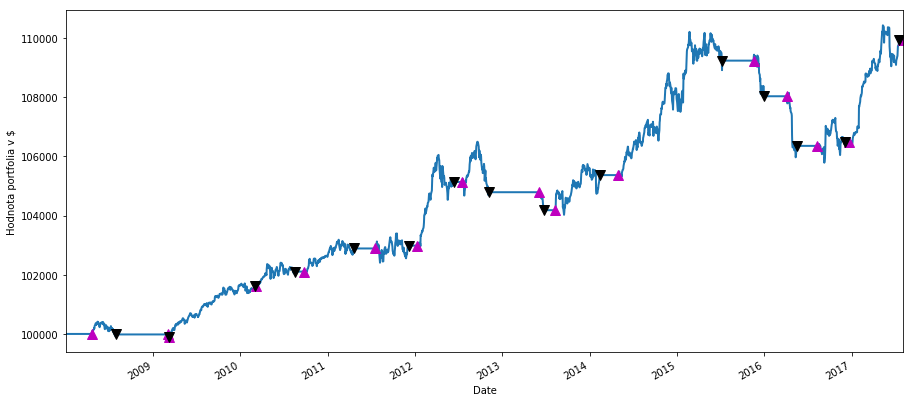

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(111, ylabel='Hodnota portfolia v $')

# graf průběhu equity v USD
portfolio['total'].plot(ax=ax1, lw=2.)

# vložení vstupů do pozic
ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# zobrazení připraveného grafu
plt.show()

Graf vývoje hodnoty portfolia při obchodování jednoduché strategie na bázi klouzavých průměrů.

# Závěr

Připravil jsem strategii, která (pouze) nakupuje akcie společnosti Apple. Backtest ukázal, že v případě obchodování této strategie od roku 2008 cca do poloviny roku 2017, zhodnotil bych svůj kapitál. Tohle je ale samozřejmě výukový příklad a obchodovat jen na základě tohoto backtestu by nemuselo dopadnout dobře. Zkuste si zkopírovat kód a nastavit datum obchodování jen na rok 2015 (od 1.1.2015 do 1.1.2016). Ale to je už jiná kapitola.

Je vidět, že sestavení své vlastní strategie (14 řádků kódu) a následný backtest (10 řádků kódu) nemusí být vůbec složitý. Následně si jednoduše můžu zobrazit výsledek a ihned na první pohled vidět, zda má vůbec smysl se podobnou strategií dál zabývat.